# Use Text Classification to Indentify case category

## **Executive summary**

### **Project overview and goals**
The goal of this project is to build a robust machine learning model to automate the categorization of support cases. This model will analyze the text fields, specifically the "Short Description" and "Description," of a case and assign it to the correct category for routing to the appropriate support queue. The categorization hierarchy consists of two levels:

- **Level 1 (Parent Categories):** "Incident" and "Service Request."
- **Level 2 (Child Categories):** Subcategories under each parent category:
    - **Incident:** "Platform Issue" and "Integration Issue."
    - **Service Request:** "User Help" and "User Access."

The model employs a two-step binary classification approach:
1) **Parent Category Classification:** Determines whether a case belongs to "Incident" or "Service Request."
2) **Child Category Classification:** Assigns one of the four child categories based on the parent category.

To achieve this, we evaluate and tune four text classification algorithms: **Logistic Regression, Support Vector Machine (SVM), Decision Tree,** and **Naive Bayes.** Key performance metrics include **Accuracy, Precision, Recall,** and **F1-Score,** with a particular emphasis on **Recall** to minimize the risk of misclassifying incidents, where timely response is critical.

### **Usage** 
This project addresses a real-world problem faced by support teams. I lead four support teams managing distinct areas of expertise, and this model will be integrated into a chatbot that assists users in raising tickets by directing their queries to the appropriate support queue. The chatbot will:

 - Parse user inputs about issues or questions.
 - Automatically categorize and assign cases to the correct team, reducing delays in issue resolution.
   
Future iterations of the project aim to enhance the system by identifying similar past tickets and sharing their resolutions with support engineers, enabling quicker problem resolution.

### **Data and Testing**
The project leverages two years of historical support case data, with "Short Description" and "Description" fields serving as the primary input features. Each case is tagged with corresponding Parent Tags and Child New Tags columns, which serve as ground truth labels for training and validation. The model's performance will also be tested on unseen data from the last two months, ensuring its effectiveness in real-world scenarios.


### **Lets Start**

### **Load Data**
Lets load the data from the file containing two year cases. 

In [94]:
import pandas as pd

# Load the Excel file into a DataFrame
file_path = 'Working_data2.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows and summarize the data
data.head(), data.info(), data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Short description        1850 non-null   object
 1   Description              1849 non-null   object
 2   Close notes              1822 non-null   object
 3   Comments and Work notes  1847 non-null   object
 4   Child New Tags           1850 non-null   object
 5   Parent Tags              1819 non-null   object
dtypes: object(6)
memory usage: 86.8+ KB


(                                   Short description  \
 0  MyTech Business Application Support: gehc edel...   
 1  MyTech Business Application Support: gehc edel...   
 2  MyTech Business Application Support: gehc edel...   
 3                                    User Management   
 4                Not able to download files from FFA   
 
                                          Description  \
 0  1) What is the URL of the eDelivery applicatio...   
 1  Please migrate the attached email template to ...   
 2  1) What is the URL of the eDelivery applicatio...   
 3  1) What is the URL of the eDelivery applicatio...   
 4  1) What is the URL of the eDelivery applicatio...   
 
                                          Close notes  \
 0  Issue: MyTech Business Application Support: ge...   
 1  Issue: gehc edelivery | Please migrate the att...   
 2  Issue: MyTech Business Application Support: ge...   
 3  Issue: User Management\nAnalysis: Need to prov...   
 4  Issue: Not able to down

### **Data Preprocessing**
- We will be uusing Short description and description and comments columns as inputs.
- Perform basic text cleanup like lower case and remove stop words. 
- Vectorize the combined text using TF-IDF Vectorizer

#### NER
We will remove person names as they are irrelevant . Want to keep other name like names of application as they will help in case categorization. 
Using **Spacy** for this.

In [95]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Load spaCy English tokenizer
nlp = spacy.load('en_core_web_sm')

# Function to remove person names using spaCy's NER
def remove_person_names(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.ent_type_ != 'PERSON'])



# Combine text fields
data['combined_text'] = data['Short description'].fillna('') + ' ' + data['Description'].fillna('') + ' ' + data['Comments and Work notes'].fillna('')

# Clean and remove person names
data['combined_text'] = data['combined_text'].apply(lambda x: x.lower())  # Convert to lower case
data['combined_text'] = data['combined_text'].apply(lambda x: remove_person_names(x))
data['combined_text'] = data['combined_text'].str.replace('[^\w\s]', '', regex=True)  # Remove punctuation
data['combined_text'] = data['combined_text'].str.replace('\d+', '', regex=True)  # Remove digits

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Vectorize the combined text
X = tfidf_vectorizer.fit_transform(data['combined_text'])
y = data['Parent Tags']  # Target variable

# Output the shape of X to confirm the vectorization
print("Shape of vectorized text data:", X.shape)


Shape of vectorized text data: (1850, 12620)


Remove 0 or nans from y

In [96]:
import pandas as pd


# Check initial condition
print("Initial shape of target 'y':", y.shape)

# Create a mask where y is not '0' and not NaN
mask = (y != 0) & (y.notna())

# Apply this mask to both X and y
X_filtered = X[mask]
y_filtered = y[mask]

# Check the shapes after filtering
print("Filtered shape of target 'y':", y_filtered.shape)
print("Filtered shape of features 'X':", X_filtered.shape)

Initial shape of target 'y': (1850,)
Filtered shape of target 'y': (1819,)
Filtered shape of features 'X': (1819, 12620)


### Split data
split data into test and train stes.

In [97]:
from sklearn.model_selection import train_test_split

# Split the filtered data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


# Output the shapes of the training and test sets to confirm the split
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (1455, 12620)
Test set shape: (364, 12620)


verify data distribution

In [98]:
# Check the distribution of classes in the training and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("Test set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
Parent Tags
Service Request    0.789691
Incident           0.210309
Name: proportion, dtype: float64
Test set class distribution:
Parent Tags
Service Request    0.758242
Incident           0.241758
Name: proportion, dtype: float64


#### Lets apply all algorithms one by one with default values

##### Logistic regression

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
log_reg_preds = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_preds))

Logistic Regression Classification Report:
                 precision    recall  f1-score   support

       Incident       0.90      0.10      0.18        88
Service Request       0.78      1.00      0.87       276

       accuracy                           0.78       364
      macro avg       0.84      0.55      0.53       364
   weighted avg       0.81      0.78      0.71       364



##### Support Vector Machine (SVM)

In [100]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Make predictions and evaluate the model
svm_preds = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))


SVM Classification Report:
                 precision    recall  f1-score   support

       Incident       0.74      0.16      0.26        88
Service Request       0.79      0.98      0.87       276

       accuracy                           0.78       364
      macro avg       0.76      0.57      0.57       364
   weighted avg       0.77      0.78      0.73       364



##### Naive Bayes

In [101]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Make predictions and evaluate the model
nb_preds = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_preds))

Naive Bayes Classification Report:
                 precision    recall  f1-score   support

       Incident       0.00      0.00      0.00        88
Service Request       0.76      1.00      0.86       276

       accuracy                           0.76       364
      macro avg       0.38      0.50      0.43       364
   weighted avg       0.57      0.76      0.65       364



C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

##### Decision tree

In [102]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions and evaluate the model
dt_preds = dt.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_preds))


Decision Tree Classification Report:
                 precision    recall  f1-score   support

       Incident       0.46      0.41      0.43        88
Service Request       0.82      0.85      0.83       276

       accuracy                           0.74       364
      macro avg       0.64      0.63      0.63       364
   weighted avg       0.73      0.74      0.74       364



#### Lets tune each model to get best parameters
##### Logistic Regression Hyperparameter Tuning

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Prevent centering for sparse data
    ('log_reg', LogisticRegression(max_iter=10000))  # Increase max_iter for convergence
])

# Define the parameter grid for Logistic Regression
param_grid_log_reg = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'log_reg__penalty': ['l1', 'l2'],  # L1 and L2 regularization
    'log_reg__solver': ['liblinear', 'saga']  # Solvers that support L1 penalty
}

# Initialize the GridSearchCV object
grid_log_reg = GridSearchCV(
    pipeline,
    param_grid_log_reg,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit the grid search
grid_log_reg.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters for Logistic Regression:", grid_log_reg.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_log_reg.best_score_))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Logistic Regression: {'log_reg__C': 1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga'}
Best cross-validation score: 0.83


##### Support Vector Machine (SVM) Hyperparameter Tuning

In [104]:
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize the GridSearchCV object for SVM
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', verbose=1)
grid_svm.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_svm.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.83


##### Decision Tree Hyperparameter Tuning

In [105]:
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the GridSearchCV object for Decision Tree
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', verbose=1)
grid_dt.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_dt.best_score_))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation score: 0.80


##### Naive Bayes Tuning

In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Multinomial Naive Bayes
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Smoothing parameter
}

# Initialize the GridSearchCV object for Naive Bayes
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy', verbose=1)
grid_nb.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters for Naive Bayes:", grid_nb.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_nb.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Naive Bayes: {'alpha': 0.1}
Best cross-validation score: 0.81


#### Comparison
Lets compare best parameters of all models.

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Create a dictionary to store the metrics
model_metrics = {
    'Model': ['Logistic Regression', 'SVM', 'Decision Tree', 'Naive Bayes'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Evaluate each model and store the metrics
models = [grid_log_reg.best_estimator_, grid_svm.best_estimator_, grid_dt.best_estimator_, grid_nb.best_estimator_]
for model, name in zip(models, model_metrics['Model']):
    y_pred = model.predict(X_test)
    model_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    model_metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    model_metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    model_metrics['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Convert metrics to DataFrame for easier plotting
import pandas as pd
metrics_df = pd.DataFrame(model_metrics)


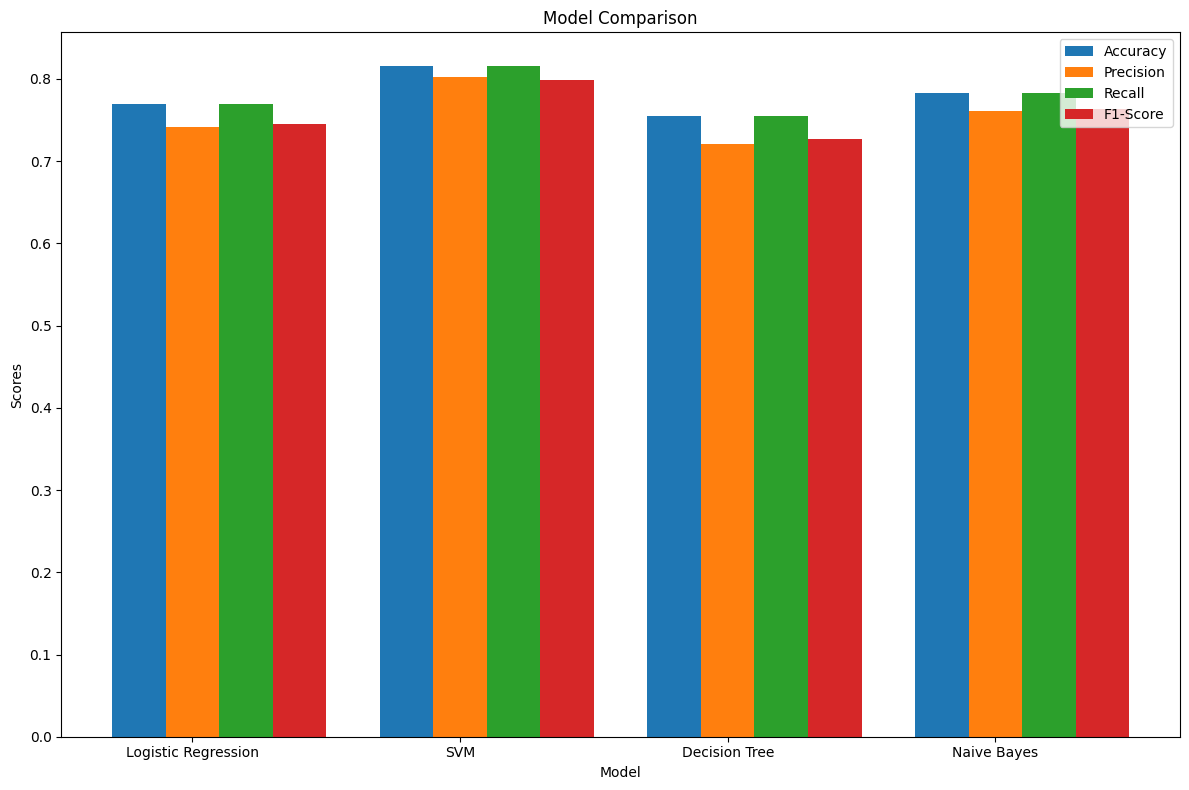

In [109]:
# Set the plot size
plt.figure(figsize=(12, 8))

# Number of models
n_models = len(metrics_df)
index = range(n_models)

# Plotting
bar_width = 0.2
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
    plt.bar([p + bar_width*i for p in index],
            metrics_df[metric],
            bar_width,
            label=metric)

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks([p + bar_width for p in index], metrics_df['Model'])
plt.legend()

plt.tight_layout()
plt.show()


#### **Child tag**
Now lets build model for Child tags.

##### Divide data based on parent tags

In [82]:
# Filter data for "Incident" parent tag
incident_data = data[data['Parent Tags'] == 'Incident']
X_incident = tfidf_vectorizer.transform(incident_data['combined_text'])
y_incident = incident_data['Child New Tags']

# Filter data for "Service Request" parent tag
service_request_data = data[data['Parent Tags'] == 'Service Request']
X_service_request = tfidf_vectorizer.transform(service_request_data['combined_text'])
y_service_request = service_request_data['Child New Tags']


##### Split

In [83]:
# Split data for "Incident" classification
X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(X_incident, y_incident, test_size=0.2, random_state=42)

# Split data for "Service Request" classification
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(X_service_request, y_service_request, test_size=0.2, random_state=42)


##### Default Algorithms performance
We will use **Logistic Regression** and SVM for second level classification as they performed the best 

Logistic regression

In [84]:
# Train model for "Incident" classification
log_reg_inc = LogisticRegression(random_state=42)
log_reg_inc.fit(X_train_inc, y_train_inc)
predictions_inc = log_reg_inc.predict(X_test_inc)
print("Classification Report for 'Incident' Parent Tag:")
print(classification_report(y_test_inc, predictions_inc))

# Train model for "Service Request" classification
log_reg_sr = LogisticRegression(random_state=42)
log_reg_sr.fit(X_train_sr, y_train_sr)
predictions_sr = log_reg_sr.predict(X_test_sr)
print("Classification Report for 'Service Request' Parent Tag:")
print(classification_report(y_test_sr, predictions_sr))


Classification Report for 'Incident' Parent Tag:
                   precision    recall  f1-score   support

integration issue       0.90      0.87      0.89        54
   platform issue       0.74      0.80      0.77        25

         accuracy                           0.85        79
        macro avg       0.82      0.84      0.83        79
     weighted avg       0.85      0.85      0.85        79

Classification Report for 'Service Request' Parent Tag:
              precision    recall  f1-score   support

 user access       0.81      0.76      0.79       155
   user help       0.74      0.79      0.76       130

    accuracy                           0.78       285
   macro avg       0.77      0.78      0.77       285
weighted avg       0.78      0.78      0.78       285



SVM

In [85]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM for "Incident" classification
svm_inc = SVC(kernel='linear', random_state=42)  
svm_inc.fit(X_train_inc, y_train_inc)
predictions_inc_svm = svm_inc.predict(X_test_inc)
print("SVM Classification Report for 'Incident' Parent Tag:")
print(classification_report(y_test_inc, predictions_inc_svm))

# Train SVM for "Service Request" classification
svm_sr = SVC(kernel='linear', random_state=42)
svm_sr.fit(X_train_sr, y_train_sr)
predictions_sr_svm = svm_sr.predict(X_test_sr)
print("SVM Classification Report for 'Service Request' Parent Tag:")
print(classification_report(y_test_sr, predictions_sr_svm))


SVM Classification Report for 'Incident' Parent Tag:
                   precision    recall  f1-score   support

integration issue       0.96      0.89      0.92        54
   platform issue       0.79      0.92      0.85        25

         accuracy                           0.90        79
        macro avg       0.88      0.90      0.89        79
     weighted avg       0.91      0.90      0.90        79

SVM Classification Report for 'Service Request' Parent Tag:
              precision    recall  f1-score   support

 user access       0.81      0.81      0.81       155
   user help       0.77      0.78      0.77       130

    accuracy                           0.79       285
   macro avg       0.79      0.79      0.79       285
weighted avg       0.79      0.79      0.79       285



##### Hyperparameter Tuning for Logistic Regression

For "Incident" Parent Tag

In [86]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid_log_reg_inc = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers for small datasets
    'penalty': ['l2']  # L2 regularization
}


# Initialize and fit GridSearchCV for "Incident"
grid_log_reg_inc = GridSearchCV(LogisticRegression(random_state=42), param_grid_log_reg_inc, cv=5, scoring='accuracy', verbose=1)
grid_log_reg_inc.fit(X_train_inc, y_train_inc)

# Output the best parameters and score
print("Best parameters for Logistic Regression (Incident):", grid_log_reg_inc.best_params_)
print("Best cross-validation score for Logistic Regression (Incident): {:.2f}".format(grid_log_reg_inc.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression (Incident): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression (Incident): 0.83


service request

In [87]:
param_grid_log_reg_sr = param_grid_log_reg_inc  # Using the same grid

# Initialize and fit GridSearchCV for "Service Request"
grid_log_reg_sr = GridSearchCV(LogisticRegression(random_state=42), param_grid_log_reg_sr, cv=5, scoring='accuracy', verbose=1)
grid_log_reg_sr.fit(X_train_sr, y_train_sr)

# Output the best parameters and score
print("Best parameters for Logistic Regression (Service Request):", grid_log_reg_sr.best_params_)
print("Best cross-validation score for Logistic Regression (Service Request): {:.2f}".format(grid_log_reg_sr.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression (Service Request): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for Logistic Regression (Service Request): 0.82


##### Hyperparameter Tuning for SVM

For "Incident" Parent Tag

In [88]:
# Define the parameter grid for SVM
param_grid_svm_inc = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Linear and RBF kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient
}


# Initialize and fit GridSearchCV for "Incident"
grid_svm_inc = GridSearchCV(SVC(random_state=42), param_grid_svm_inc, cv=5, scoring='accuracy', verbose=1)
grid_svm_inc.fit(X_train_inc, y_train_inc)

# Output the best parameters and score
print("Best parameters for SVM (Incident):", grid_svm_inc.best_params_)
print("Best cross-validation score for SVM (Incident): {:.2f}".format(grid_svm_inc.best_score_))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for SVM (Incident): {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVM (Incident): 0.83


For "Service Request" Parent Tag

In [89]:
param_grid_svm_sr = param_grid_svm_inc  # Using the same grid

# Initialize and fit GridSearchCV for "Service Request"
grid_svm_sr = GridSearchCV(SVC(random_state=42), param_grid_svm_sr, cv=5, scoring='accuracy', verbose=1)
grid_svm_sr.fit(X_train_sr, y_train_sr)

# Output the best parameters and score
print("Best parameters for SVM (Service Request):", grid_svm_sr.best_params_)
print("Best cross-validation score for SVM (Service Request): {:.2f}".format(grid_svm_sr.best_score_))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for SVM (Service Request): {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVM (Service Request): 0.81


Collect Metrics for Child Classification

In [90]:
# Retrieve the best models after GridSearchCV
best_log_reg_inc = grid_log_reg_inc.best_estimator_
best_log_reg_sr = grid_log_reg_sr.best_estimator_
best_svm_inc = grid_svm_inc.best_estimator_
best_svm_sr = grid_svm_sr.best_estimator_


In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Define dictionaries to hold metrics
metrics_incident = {'Model': ['Logistic Regression', 'SVM'], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
metrics_service_request = {'Model': ['Logistic Regression', 'SVM'], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Incident metrics
models_incident = [best_log_reg_inc, best_svm_inc]
for model in models_incident:
    predictions = model.predict(X_test_inc)
    metrics_incident['Accuracy'].append(accuracy_score(y_test_inc, predictions))
    metrics_incident['Precision'].append(precision_score(y_test_inc, predictions, average='weighted'))
    metrics_incident['Recall'].append(recall_score(y_test_inc, predictions, average='weighted'))
    metrics_incident['F1-Score'].append(f1_score(y_test_inc, predictions, average='weighted'))

# Service Request metrics
models_service_request = [best_log_reg_sr, best_svm_sr]
for model in models_service_request:
    predictions = model.predict(X_test_sr)
    metrics_service_request['Accuracy'].append(accuracy_score(y_test_sr, predictions))
    metrics_service_request['Precision'].append(precision_score(y_test_sr, predictions, average='weighted'))
    metrics_service_request['Recall'].append(recall_score(y_test_sr, predictions, average='weighted'))
    metrics_service_request['F1-Score'].append(f1_score(y_test_sr, predictions, average='weighted'))

# Convert to DataFrame for easier visualization
df_incident = pd.DataFrame(metrics_incident)
df_service_request = pd.DataFrame(metrics_service_request)


##### Plot the Metrics

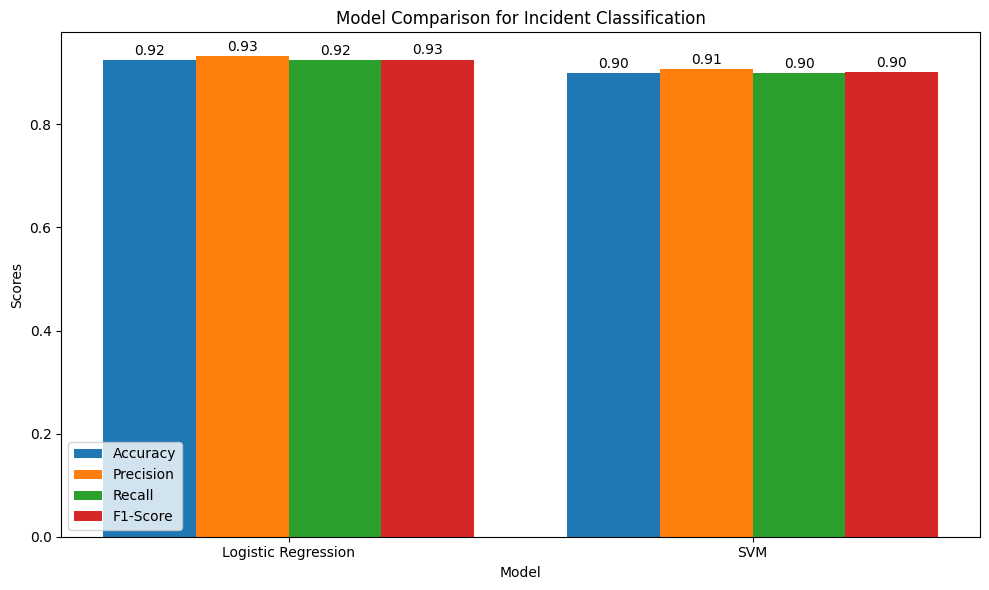

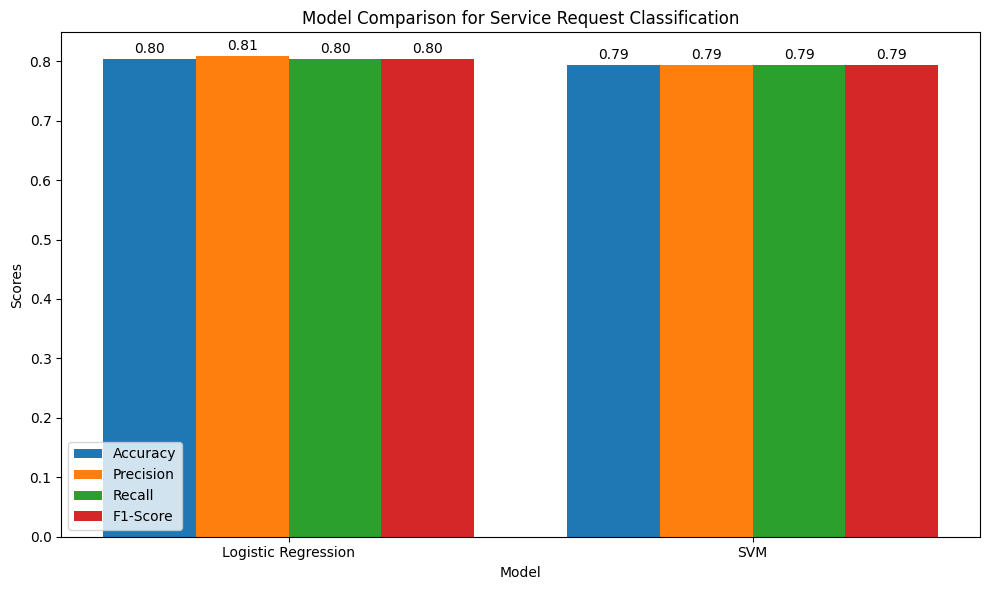

In [92]:
# Visualization for "Incident" classification
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(df_incident))

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
    bars = plt.bar([x + bar_width * i for x in index], df_incident[metric], bar_width, label=metric)
    # Add score text on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison for Incident Classification')
plt.xticks([x + bar_width * 1.5 for x in index], df_incident['Model'])
plt.legend()
plt.tight_layout()
plt.show()

# Visualization for "Service Request" classification
plt.figure(figsize=(10, 6))
index = range(len(df_service_request))

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
    bars = plt.bar([x + bar_width * i for x in index], df_service_request[metric], bar_width, label=metric)
    # Add score text on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison for Service Request Classification')
plt.xticks([x + bar_width * 1.5 for x in index], df_service_request['Model'])
plt.legend()
plt.tight_layout()
plt.show()


##### Save the Models 

In [93]:
import joblib

# Save the parent tag model
joblib.dump(grid_log_reg.best_estimator_, 'parent_tag_model_reg.pkl')
joblib.dump(grid_svm.best_estimator_, 'parent_tag_model_svm.pkl')
# Save the child tag models
joblib.dump(best_log_reg_inc, 'incident_child_model_reg.pkl')
joblib.dump(best_log_reg_sr, 'service_request_child_model_reg.pkl')
joblib.dump(best_svm_inc, 'incident_child_model_svm.pkl')
joblib.dump(best_svm_sr, 'service_request_child_model_svm.pkl')

['service_request_child_model_svm.pkl']

#### Model Testing
Lets test the model with Unseen data . Sinbce **Logistic Regression** preformed better, we will use that.

Load unseen data

In [124]:
# Load unseen data
unseen_data = pd.read_excel('test_data.xlsx')  

# Combine text columns
unseen_data['combined_text'] = (
    unseen_data['Short description'].fillna('') + ' ' +
    unseen_data['Description'].fillna('')
)

# Clean the text
unseen_data['combined_text'] = unseen_data['combined_text'].str.lower()
unseen_data['combined_text'] = unseen_data['combined_text'].str.replace('[^\w\s]', '', regex=True)
unseen_data['combined_text'] = unseen_data['combined_text'].str.replace('\d+', '', regex=True)

# Transform the text using the existing TF-IDF vectorizer
X_unseen = tfidf_vectorizer.transform(unseen_data['combined_text'])



Load Models for **Logistic regression**

In [125]:
import joblib

# Load the parent tag and child tag models
parent_tag_model = joblib.load('parent_tag_model_reg.pkl')
incident_child_model = joblib.load('incident_child_model_reg.pkl')
service_request_child_model = joblib.load('service_request_child_model_reg.pkl')


##### Predict parent tags

In [126]:
# Predict parent tags
unseen_data['Parent Tag Prediction'] = parent_tag_model.predict(X_unseen)


##### Predict Child Tags Based on Parent Tag

In [127]:
# Function to predict child tags
def predict_child_tags(row):
    text_vectorized = tfidf_vectorizer.transform([row['combined_text']])
    if row['Parent Tag Prediction'] == 'Incident':
        return incident_child_model.predict(text_vectorized)[0]
    elif row['Parent Tag Prediction'] == 'Service Request':
        return service_request_child_model.predict(text_vectorized)[0]
    else:
        return "Unknown"

# Apply the function to predict child tags
unseen_data['Child Tag Prediction'] = unseen_data.apply(predict_child_tags, axis=1)


##### Review Results

In [128]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate parent tag predictions
print("Parent Tag Classification Report:")
parent_report = classification_report(unseen_data['Parent Tags'], unseen_data['Parent Tag Prediction'])
print(parent_report)

# Calculate overall accuracy for parent tags
parent_accuracy = accuracy_score(unseen_data['Parent Tags'], unseen_data['Parent Tag Prediction'])
print(f"Parent Tag Accuracy: {parent_accuracy:.2f}")

# Evaluate child tag predictions
print("\nChild Tag Classification Report:")
child_report = classification_report(unseen_data['Child New Tags'], unseen_data['Child Tag Prediction'])
print(child_report)

# Calculate overall accuracy for child tags
child_accuracy = accuracy_score(unseen_data['Child New Tags'], unseen_data['Child Tag Prediction'])
print(f"Child Tag Accuracy: {child_accuracy:.2f}")



Parent Tag Classification Report:
                 precision    recall  f1-score   support

       Incident       0.77      0.70      0.73        86
Service Request       0.85      0.89      0.87       164

       accuracy                           0.82       250
      macro avg       0.81      0.79      0.80       250
   weighted avg       0.82      0.82      0.82       250

Parent Tag Accuracy: 0.82

Child Tag Classification Report:
                   precision    recall  f1-score   support

integration issue       0.69      0.64      0.67        56
   platform issue       0.54      0.47      0.50        30
      user access       0.79      0.68      0.73        82
        user help       0.60      0.74      0.67        82

         accuracy                           0.67       250
        macro avg       0.66      0.63      0.64       250
     weighted avg       0.68      0.67      0.67       250

Child Tag Accuracy: 0.67
